## Interpretation of LR and RF models trained on UniRef90 dataset for multiclass classification

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/..']

In [2]:
from utils import kmer_utils, utils
import pandas as pd
import numpy as np
import joblib

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE


In [3]:
input_dir = "/home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/"
input_file_names = ["uniref90_final_msl1114.csv"]

label_groupings = {"Human": [ "Homo sapiens" ],
                  "Desert warthog": [ "Phacochoerus aethiopicus" ],
                  "Lesser bandicoot rat": [ "Bandicota bengalensis" ],
                  "Horse": [ "Equus caballus" ],
                  "Goat": [ "Capra hircus" ],
                  "Red junglefowl": [ "Gallus gallus" ],
                  "Wood mouse": [ "Apodemus sylvaticus" ],
                  "Cattle": [ "Bos taurus" ],
                  "Others": [ "*" ]}
host_classes = ["Homo sapiens",  "Phacochoerus aethiopicus",    "Bandicota bengalensis",     "Equus caballus",   "Capra hircus", 
                "Gallus gallus",   "Apodemus sylvaticus",     "Bos taurus",  "Others"]

split_col = "split"
k = 3
sequence_settings= {
    "sequence_col": "seq",
    "id_col": "uniref90_id",
    
}
    
classification_settings =  {
    "train_proportion": 0.8,
    "batch_size": 8,
    "max_sequence_length": 1115,
    "pad_sequence_val": 0,
    "truncate": True
}

label_settings = {
    "label_col": "virus_host_name",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

lr_model = {
    "C": [0.01, 0.1, 1],
    "multiclass_type": "multinomial"
}

rf_model = {
    "n_estimators": [10, 100, 1000],
    "max_depth": [3, 5]
}

### Load the datasets

In [4]:
def load_dataset(input_dir, input_file_names, seed, train_proportion, kmer_keys=None):
    id_col = sequence_settings["id_col"]
    label_col = label_settings["label_col"]
    sequence_col = sequence_settings["sequence_col"]
    df = utils.read_dataset(input_dir, input_file_names, 
                            cols=[id_col, sequence_col, label_col])
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    train_df, test_df = utils.split_dataset(df, seed, classification_settings["train_proportion"], stratify_col=label_col)
    train_df[split_col] = "train"
    test_df[split_col] = "test"
    df = pd.concat([train_df, test_df])
    print(f"Loaded dataset size = {df.shape}")
    
    kmer_df = kmer_utils.compute_kmer_features(df, k, id_col, sequence_col, label_col, kmer_keys)
    print(f"kmer_df size = {kmer_df.shape}")
    
    kmer_df = kmer_df.join(df["split"], on=id_col, how="left")
    print(f"kmer_df size after join with split on id = {kmer_df.shape}")
    return index_label_map, kmer_df

### Load models

In [5]:
print("Loading models")
lr_model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20230705/host_multi_msl1114_baseline/kmer_k3_virus_host_name_multi_kmer_k3-loss_ce_itr4_lr_model.joblib"
lr_model = joblib.load(lr_model_path)
print(lr_model)

rf_model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20230705/host_multi_msl1114_baseline/kmer_k3_virus_host_name_multi_kmer_k3-loss_ce_itr4_rf_model.joblib"
rf_model =joblib.load(rf_model_path)
print(rf_model)

Loading models
LogisticRegression(C=1, class_weight='balanced', max_iter=5000,
                   multi_class='multinomial', n_jobs=-1, penalty='l1',
                   solver='saga')
RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=1000)


### Training-based interpretation
#### Encoding visualization - all viruses, all hosts

In [72]:
def compute_dataset_representations(baseline_model, df, label_col, id_col):
    df = df[df[split_col] == "train"]
    features = baseline_model.feature_names_in_
    coeffs = baseline_model.coef_
    print(f"coeffs shape = {coeffs.shape}")
    
    features_df = df[features]
    coeff_df = coeffs[df[label_col], :]
    
    print(f"df.size = {df.shape}")
    print(f"features_df.size = {features_df.shape}")
    print(f"coeff_df.size = {coeff_df.shape}")
    
    embed_df = features_df.multiply(coeff_df)
    print(f"embed_df shape = {embed_df.shape}")
    embed_df = embed_df.join(df[label_col], on=id_col, how="left")
    print(f"Final embed_df shape = {embed_df.shape}")
    return features_df, coeff_df, embed_df


def visualize_dataset(rep_df, feature_cols, label_col, tsne_perplexity):
    print(rep_df.columns)
    rep_df = rep_df.head(2048)
    X = rep_df[feature_cols]
    print(X.columns)
    tsne_model = TSNE(n_components=2, verbose=1, init="pca", learning_rate="auto", perplexity=tsne_perplexity).fit(X)
    X_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(X_emb.shape)
    print(X_emb)
    X_emb[label_col] = rep_df[label_col].values
    X_emb[label_col] = X_emb[label_col].map(index_label_map)
    sns.scatterplot(data=X_emb, x=0, y=1, hue=label_col)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    

### Logistic Regression

In [56]:
print(lr_model.coef_.shape)
print(lr_model.feature_names_in_)
print(lr_model.get_params())

(9, 500)
['PIP' 'FII' 'NIL' 'GIL' 'GPS' 'YNI' 'CLW' 'FFP' 'AAP' 'IPS' 'LLA' 'YSL'
 'WAF' 'GNC' 'GAK' 'RRF' 'GTV' 'SPF' 'AVT' 'HLP' 'FFL' 'PIF' 'PHC' 'MLL'
 'LVV' 'WPK' 'CRT' 'PSC' 'VIW' 'LSP' 'LQS' 'MDD' 'GFR' 'LDS' 'GSS' 'SCC'
 'PLL' 'KNP' 'DGN' 'KTC' 'WMM' 'FPS' 'GGV' 'IPL' 'PKF' 'IPQ' 'ESL' 'RRA'
 'PFL' 'DPA' 'TFG' 'PAG' 'SWA' 'PPP' 'PMG' 'ALY' 'PPL' 'HCL' 'ILT' 'VLL'
 'FYH' 'LFT' 'VFL' 'ICP' 'QFS' 'LSL' 'IWM' 'VNR' 'SMF' 'ASA' 'YKT' 'PAR'
 'FCL' 'QGT' 'AFP' 'SRY' 'LLT' 'FTA' 'VPF' 'FGR' 'QSL' 'LVG' 'LLD' 'PHN'
 'YLW' 'PLH' 'TAS' 'VVR' 'TPP' 'QNL' 'VTN' 'TVP' 'AKS' 'PAP' 'TVW' 'ARV'
 'ILG' 'RVT' 'AQG' 'CSR' 'IFL' 'HDS' 'PTS' 'RYV' 'GML' 'PAS' 'TSL' 'DFS'
 'LTT' 'FMG' 'TSN' 'LGW' 'RKI' 'RFS' 'SSN' 'GVG' 'VLG' 'GIH' 'LGQ' 'AFG'
 'SGF' 'LTN' 'LGL' 'PNL' 'WWT' 'GST' 'MLP' 'TKR' 'LRR' 'FAV' 'NFL' 'SLN'
 'CLR' 'WAS' 'IHL' 'CTK' 'DSC' 'LGG' 'GTS' 'HSP' 'SLT' 'AAM' 'PNK' 'LSW'
 'GQN' 'SSW' 'NSR' 'ARF' 'PID' 'LGI' 'SDG' 'AQF' 'VVD' 'NRP' 'TST' 'RLS'
 'SGL' 'ICS' 'VAR' 'FTS' 'ILL' 'LSS' 'PII'

In [58]:
index_label_map, kmer_df = load_dataset(input_dir,
                       input_file_names,
                       seed=79221635, train_proportion=0.8, kmer_keys=lr_model.feature_names_in_)

input file: /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/uniref90_final_msl1114.csv, size = (18292, 3)
Size of input dataset = (18292, 3)
Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4 5 6 3 2 1 7 0 8]
Splitting dataset with seed=79221635, train_proportion=0.8, stratify_col=virus_host_name
Size of train_dataset = (14633, 3)
Size of test_dataset = (3659, 3)
Loaded datas

In [62]:
print(kmer_df.shape)
kmer_df.head()

(18292, 502)


,PIP,FII,NIL,GIL,GPS,YNI,CLW,FFP,AAP,IPS,...,TTT,ARL,NLY,NPD,IIF,DVV,VWL,FRK,virus_host_name,split
uniref90_id,,,,,,,,,,,,,,,,,,,,,
UniRef90_A0A0U3C4Z2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,4,train
UniRef90_Q767U5,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,4,train
UniRef90_A0A0X9GBF6,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,4,train
UniRef90_A0A515J2X9,0,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,4,train
UniRef90_A7WRN4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,2,4,train


In [63]:
features_df, coeff_df, embed_df = compute_dataset_representations(lr_model, kmer_df, label_settings["label_col"], sequence_settings["id_col"])

coeffs shape = (9, 500)
df.size = (14633, 502)
features_df.size = (14633, 500)
coeff_df.size = (14633, 500)
embed_df shape = (14633, 500)
Final embed_df shape = (14633, 501)


In [64]:
embed_df.head()

,PIP,FII,NIL,GIL,GPS,YNI,CLW,FFP,AAP,IPS,...,QHG,TTT,ARL,NLY,NPD,IIF,DVV,VWL,FRK,virus_host_name
uniref90_id,,,,,,,,,,,,,,,,,,,,,
UniRef90_A0A0U3C4Z2,0.0,-0.000000,-0.0,0.0,-0.0,-0.0,0.0,0.000000,0.000000,-0.000000,...,0.000,0.0,0.000762,4.119108,0.000000,0.0,-0.000000,0.000000,0.888041,4
UniRef90_Q767U5,0.0,-0.000592,-0.0,0.0,-0.0,-0.0,0.0,0.000000,0.000000,-0.002433,...,0.000,0.0,0.000000,0.000000,0.000000,0.0,-0.000000,0.000046,0.000000,4
UniRef90_A0A0X9GBF6,0.0,-0.000592,-0.0,0.0,-0.0,-0.0,0.0,0.000000,0.000000,-0.002433,...,0.000,0.0,0.000000,0.000000,0.000000,0.0,-0.000000,0.000000,0.000000,4
UniRef90_A0A515J2X9,0.0,-0.000000,-0.0,0.0,-0.0,-0.0,0.0,4.467743,0.000198,-0.000000,...,0.000,0.0,0.000000,0.000000,0.011263,0.0,-0.000000,0.000000,0.000000,4
UniRef90_A7WRN4,0.0,-0.000000,-0.0,0.0,-0.0,-0.0,0.0,0.000000,0.000000,-0.000000,...,0.014,0.0,0.000762,4.119108,0.000000,0.0,-0.020451,0.000000,1.776083,4


Index(['PIP', 'FII', 'NIL', 'GIL', 'GPS', 'YNI', 'CLW', 'FFP', 'AAP', 'IPS',
       ...
       'QHG', 'TTT', 'ARL', 'NLY', 'NPD', 'IIF', 'DVV', 'VWL', 'FRK',
       'virus_host_name'],
      dtype='object', length=501)
Index(['PIP', 'FII', 'NIL', 'GIL', 'GPS', 'YNI', 'CLW', 'FFP', 'AAP', 'IPS',
       ...
       'SLD', 'QHG', 'TTT', 'ARL', 'NLY', 'NPD', 'IIF', 'DVV', 'VWL', 'FRK'],
      dtype='object', length=500)
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2048 samples in 0.012s...
[t-SNE] Computed neighbors for 2048 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2048
[t-SNE] Computed conditional probabilities for sample 2000 / 2048
[t-SNE] Computed conditional probabilities for sample 2048 / 2048
[t-SNE] Mean sigma: 0.000000


/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.694519
[t-SNE] KL divergence after 1000 iterations: 0.750076
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2048 samples in 0.008s...
[t-SNE] Computed neighbors for 2048 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2048
[t-SNE] Computed conditional probabilities for sample 2000 / 2048
[t-SNE] Computed conditional probabilities for sample 2048 / 2048
[t-SNE] Mean sigma: 0.000000


/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.918617
[t-SNE] KL divergence after 1000 iterations: 0.751198
(2048, 2)
              0          1
0     13.877839  44.494259
1     44.372665 -47.914917
2     55.520630 -57.985737
3    -40.962391 -19.013498
4     55.090420  58.953514
...         ...        ...
2043 -14.109751 -32.885700
2044 -16.831802 -41.632458
2045  -7.382069  56.615879
2046 -54.049320 -12.330857
2047  -0.994157  32.949089

[2048 rows x 2 columns]


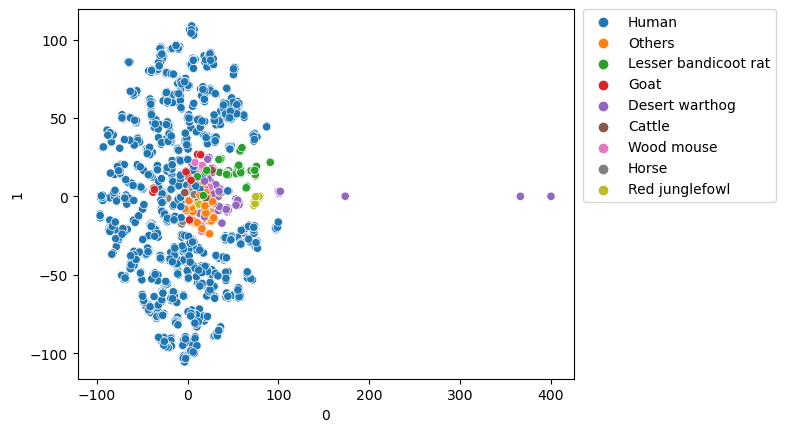

In [73]:
visualize_dataset(embed_df, lr_model.feature_names_in_, label_settings["label_col"], tsne_perplexity=5)

### Viewing the LR model coefficients

In [85]:
coeffs_df = pd.DataFrame(lr_model.coef_, columns=lr_model.feature_names_in_)
print(coeffs_df.shape)
coeffs_df.head()

(9, 500)


,PIP,FII,NIL,GIL,GPS,YNI,CLW,FFP,AAP,IPS,...,SLD,QHG,TTT,ARL,NLY,NPD,IIF,DVV,VWL,FRK
0,2.239509,0.000000,0.040970,-0.000440,-0.000230,1.152624,-2.145553,0.000000,-0.004098,0.449583,...,0.006210,-6.393228,0.001064,-2.291149,-2.959223,0.105270,3.595077,1.514298,-1.342762,-0.012358
1,0.000000,0.879642,3.092066,-0.000225,1.444879,0.841462,0.604655,2.982951,0.000000,-1.138192,...,-1.083163,2.129765,-1.808788,0.000000,0.975356,0.000000,3.475171,-0.000116,3.398737,0.000016
2,0.000000,-5.471866,0.000000,-1.679953,-1.289423,-2.887629,0.000000,0.000000,0.000000,0.000000,...,2.809298,0.000548,0.282698,1.367010,2.169791,1.031627,0.000000,-0.131099,4.843962,-0.000014
3,0.000000,0.000000,-3.322267,2.984732,7.660568,0.000000,0.000000,-0.579789,0.000000,-1.759529,...,-1.621241,0.000000,0.000000,-0.897905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,-0.000592,-0.089174,0.002418,-0.312406,-1.619596,0.000021,4.467743,0.000198,-0.002433,...,0.001076,0.014000,0.000000,0.000762,4.119108,0.011263,0.000000,-0.020451,0.000046,0.888041


In [86]:
# map the class labels
coeffs_df.index = coeffs_df.index.to_series().map(index_label_map)
print(coeffs_df.shape)
coeffs_df.head()

(9, 500)


,PIP,FII,NIL,GIL,GPS,YNI,CLW,FFP,AAP,IPS,...,SLD,QHG,TTT,ARL,NLY,NPD,IIF,DVV,VWL,FRK
Cattle,2.239509,0.000000,0.040970,-0.000440,-0.000230,1.152624,-2.145553,0.000000,-0.004098,0.449583,...,0.006210,-6.393228,0.001064,-2.291149,-2.959223,0.105270,3.595077,1.514298,-1.342762,-0.012358
Desert warthog,0.000000,0.879642,3.092066,-0.000225,1.444879,0.841462,0.604655,2.982951,0.000000,-1.138192,...,-1.083163,2.129765,-1.808788,0.000000,0.975356,0.000000,3.475171,-0.000116,3.398737,0.000016
Goat,0.000000,-5.471866,0.000000,-1.679953,-1.289423,-2.887629,0.000000,0.000000,0.000000,0.000000,...,2.809298,0.000548,0.282698,1.367010,2.169791,1.031627,0.000000,-0.131099,4.843962,-0.000014
Horse,0.000000,0.000000,-3.322267,2.984732,7.660568,0.000000,0.000000,-0.579789,0.000000,-1.759529,...,-1.621241,0.000000,0.000000,-0.897905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Human,0.000000,-0.000592,-0.089174,0.002418,-0.312406,-1.619596,0.000021,4.467743,0.000198,-0.002433,...,0.001076,0.014000,0.000000,0.000762,4.119108,0.011263,0.000000,-0.020451,0.000046,0.888041


<AxesSubplot:>

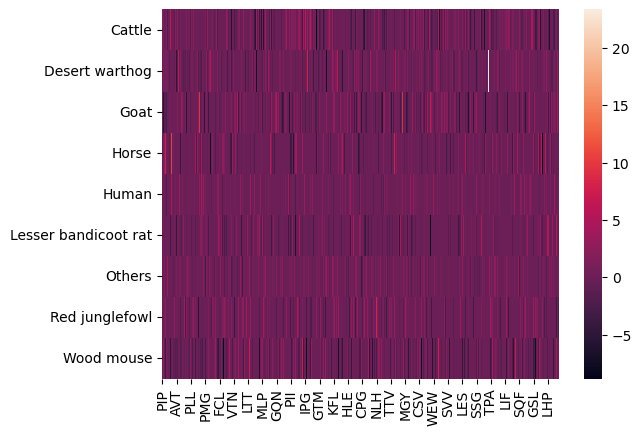

In [87]:
sns.heatmap(coeffs_df)

#### Mean of the absolute values to determine the top 30 features

In [88]:
coeffs_df_abs = coeffs_df.abs()
coeffs_df_abs_mean = coeffs_df_abs.mean(axis=0)
print(coeffs_df_abs_mean.shape)
coeffs_df_abs_mean.head()

(500,)


PIP    0.249632
FII    0.968089
NIL    1.025297
GIL    0.761392
GPS    1.851854
dtype: float64

In [89]:
# top 30 features
top30_coeffs = coeffs_df_abs_mean.nlargest(n=20)
top30_coeffs

AST    2.595177
TVN    2.365703
VVR    2.224649
RQS    2.174318
IIL    2.157070
SVI    2.022517
LGL    1.941441
DPA    1.932845
GPS    1.851854
FVQ    1.850235
QAG    1.817384
RNL    1.806327
VEL    1.788827
DVV    1.763228
QLD    1.751128
SSS    1.730805
VPN    1.727781
GSL    1.715230
LLA    1.696912
WAF    1.668274
dtype: float64

20
(9, 20)


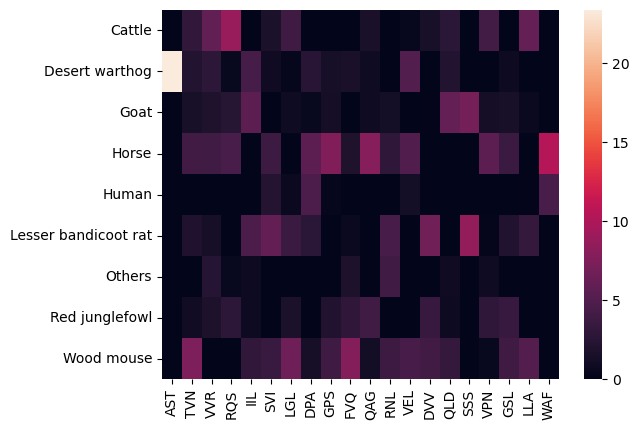

<Figure size 1200x800 with 0 Axes>

In [90]:
# heat map of the top 30 features
top30_features = top30_coeffs.index
print(len(top30_features))
print(coeffs_df[top30_features].shape)
sns.heatmap(coeffs_df_abs[top30_features])
plt.figure(figsize=(12,8))
plt.tight_layout()

### Random Forest

In [74]:
index_label_map, kmer_df = load_dataset(input_dir,
                       input_file_names,
                       seed=79221635, train_proportion=0.8, kmer_keys=rf_model.feature_names_in_)

input file: /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/uniref90_final_msl1114.csv, size = (18292, 3)
Size of input dataset = (18292, 3)
Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4 5 6 3 2 1 7 0 8]
Splitting dataset with seed=79221635, train_proportion=0.8, stratify_col=virus_host_name
Size of train_dataset = (14633, 3)
Size of test_dataset = (3659, 3)
Loaded datas

In [76]:
print(kmer_df.shape)
kmer_df.head()

(18292, 502)


,PIP,FII,NIL,GIL,GPS,YNI,CLW,FFP,AAP,IPS,...,TTT,ARL,NLY,NPD,IIF,DVV,VWL,FRK,virus_host_name,split
uniref90_id,,,,,,,,,,,,,,,,,,,,,
UniRef90_A0A0U3C4Z2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,4,train
UniRef90_Q767U5,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,4,train
UniRef90_A0A0X9GBF6,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,4,train
UniRef90_A0A515J2X9,0,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,4,train
UniRef90_A7WRN4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,2,4,train


### Viewing the RF model feature importances

In [78]:
rf_model.feature_importances_
# coeffs_df = pd.DataFrame(rf_model.coef_, columns=rf_model.feature_names_in_)
# print(coeffs_df.shape)
# coeffs_df.head()

array([5.61865770e-03, 6.47458459e-04, 3.25523106e-04, 2.39399302e-04,
       2.41018027e-04, 1.35153172e-04, 3.18695806e-05, 4.77678085e-03,
       6.70650763e-04, 1.22445571e-03, 1.00943024e-03, 8.51089089e-05,
       3.64643083e-03, 6.07753654e-03, 1.15125621e-03, 3.54907531e-04,
       1.70757072e-03, 1.20812654e-02, 1.83740143e-02, 1.08096115e-04,
       4.55733423e-04, 1.78720355e-04, 6.98724540e-03, 1.43952619e-04,
       3.39439892e-04, 3.82947223e-04, 1.30992903e-04, 4.47483683e-03,
       4.58972583e-05, 6.56655042e-03, 2.32717227e-04, 8.54022107e-04,
       3.35747165e-03, 1.34528300e-04, 2.88854098e-03, 8.88439033e-03,
       1.18302096e-03, 1.95226428e-04, 1.18550029e-03, 2.45849251e-05,
       3.14290809e-04, 4.07145453e-04, 2.25431695e-02, 1.23246101e-04,
       1.42885876e-03, 2.91068524e-04, 3.93044576e-04, 3.05233828e-03,
       2.35303872e-03, 5.78566027e-03, 4.42478929e-04, 5.99198928e-04,
       9.27177499e-03, 3.91910217e-03, 5.52805229e-03, 1.50093781e-04,
      

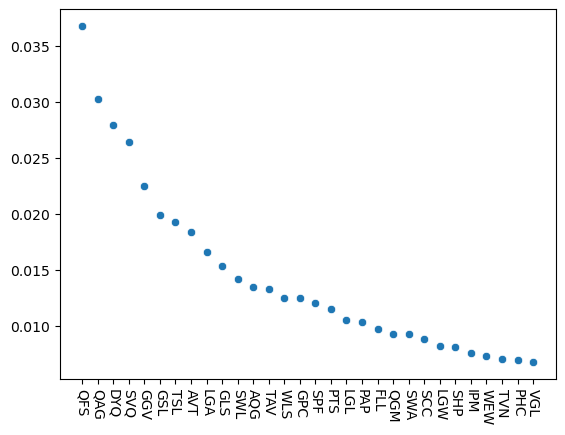

In [95]:
rf_feature_imp = pd.Series(data=rf_model.feature_importances_, index=rf_model.feature_names_in_)
rf_feature_imp_top30 = rf_feature_imp.nlargest(n=30)
sns.scatterplot(rf_feature_imp_top30)
plt.xticks(rotation=-90)
plt.show()